This code cell mounts your Google Drive to the Colab environment, allowing you to access files stored in your Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This cell sets up the source and destination paths for the dataset and selects a specified number of random images from the source directory. It then copies these selected images to the destination directory.

In [ ]:
import os
import random
import shutil

# Source dataset root (all images are inside subfolders or directly in this folder)
SRC = '/content/drive/MyDrive/SuperResolutionProject/data/raw_dataset/test'
DST = '/content/drive/MyDrive/SuperResolutionProject/data/selected_images/'

os.makedirs(DST, exist_ok=True)

# How many random images you want
NUM_IMAGES = 40

# Collect all image paths
all_imgs = []
for root, _, files in os.walk(SRC):
    for f in files:
        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff')):
            all_imgs.append(os.path.join(root, f))

print(f"Found {len(all_imgs)} images in dataset.")

# Randomly select
selected = random.sample(all_imgs, NUM_IMAGES)

# Copy to selected_images
for img in selected:
    shutil.copy(img, DST)

print(f"✅ {NUM_IMAGES} random images copied to {DST}")


Found 1080 images in dataset.
✅ 40 random images copied to /content/drive/MyDrive/SuperResolutionProject/data/selected_images/


This code cell processes the selected images to create different versions for super-resolution tasks. It creates High-Resolution (HR) images by resizing to 256x256 and Low-Resolution (LR) images by downsampling to 128x128 (x2) and 64x64 (x4). It saves these processed images into separate directories.

In [ ]:
import os
from PIL import Image
from tqdm import tqdm

# Input and output roots
SRC = '/content/drive/MyDrive/SuperResolutionProject/data/selected_images'
DST = '/content/drive/MyDrive/SuperResolutionProject/data/processed'

HR_DIR  = os.path.join(DST, 'HR')
LR2_DIR = os.path.join(DST, 'LR_x2')
LR4_DIR = os.path.join(DST, 'LR_x4')

for d in [HR_DIR, LR2_DIR, LR4_DIR]:
    os.makedirs(d, exist_ok=True)

# Process images
imgs = [f for f in os.listdir(SRC) if f.lower().endswith(('.tif', '.tiff', '.png', '.jpg', '.jpeg'))]

for f in tqdm(imgs, desc='Processing images'):
    in_path = os.path.join(SRC, f)
    stem, _ = os.path.splitext(f)

    img = Image.open(in_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Resize HR to 256x256
    hr = img.resize((256, 256), resample=Image.BICUBIC)
    hr_out = os.path.join(HR_DIR, f"{stem}.png")
    hr.save(hr_out, format='PNG')

    # Downsample
    lr2 = hr.resize((128, 128), resample=Image.BICUBIC)
    lr4 = hr.resize((64, 64), resample=Image.BICUBIC)

    lr2.save(os.path.join(LR2_DIR, f"{stem}_x2.png"), format='PNG')
    lr4.save(os.path.join(LR4_DIR, f"{stem}_x4.png"), format='PNG')

print("✅ HR, LR_x2, and LR_x4 sets created successfully.")


Processing images: 100%|██████████| 40/40 [00:04<00:00,  9.18it/s]

✅ HR, LR_x2, and LR_x4 sets created successfully.


This cell navigates to a specific directory in your Google Drive and clones two GitHub repositories: SRCNN-PyTorch and ESRGAN. It then installs the necessary Python packages for the SRCNN-PyTorch model from its `requirements.txt` file.

In [ ]:
%cd '/content/drive/MyDrive/SuperResolutionProject/models'
!git clone https://github.com/Lornatang/SRCNN-PyTorch.git
!git clone https://github.com/xinntao/ESRGAN.git

# Install requirements
!pip install -r SRCNN-PyTorch/requirements.txt

/content/drive/MyDrive/SuperResolutionProject/models
Cloning into 'SRCNN-PyTorch'...
remote: Enumerating objects: 1330, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 1330 (delta 33), reused 24 (delta 24), pack-reused 1289 (from 2)
Receiving objects: 100% (1330/1330), 1.39 MiB | 13.16 MiB/s, done.
Resolving deltas: 100% (777/777), done.
Cloning into 'ESRGAN'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 225 (delta 15), reused 14 (delta 14), pack-reused 205 (from 1)
Receiving objects: 100% (225/225), 24.86 MiB | 15.22 MiB/s, done.
Resolving deltas: 100% (85/85), done.


This code cell adds the SRCNN-PyTorch directory to the system's Python path. This is necessary to import modules and run scripts from the cloned repository.

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/SuperResolutionProject/models/SRCNN-PyTorch")

This cell attempts to navigate to the `weights` directory within the SRCNN-PyTorch repository and extract two tar.gz weight files. The output shows that the `tar` command failed, indicating that the specified files might not be valid tar archives or might not be present in that location.

In [ ]:
%cd /content/drive/MyDrive/SuperResolutionProject/models/SRCNN-PyTorch/weights
!tar -xvf srcnn_x2-T91-7d6e0623.pth.tar
!tar -xvf srcnn_x4-T91-7c460643.pth.tar

/content/drive/MyDrive/SuperResolutionProject/models/SRCNN-PyTorch/weights
tar: This does not look like a tar archive
tar: Skipping to next header
tar: Exiting with failure status due to previous errors
tar: This does not look like a tar archive
tar: Skipping to next header
tar: Exiting with failure status due to previous errors


This cell runs the `test.py` script from the SRCNN-PyTorch repository twice. The first run performs super-resolution with a scale of x2 using the `srcnn_x2` weights on the LR_x2 images. The second run uses the `srcnn_x4` weights on the LR_x4 images with a scale of x4. The results are saved in the specified output directories.

In [ ]:
# go to the repo folder that contains this test.py
%cd /content/drive/MyDrive/SuperResolutionProject/models/SRCNN-PyTorch

# x2
!python test.py \
  --weights ./weights/srcnn_x2-T91-7d6e0623.pth.tar \
  --image-folder /content/drive/MyDrive/SuperResolutionProject/data/processed/LR_x2 \
  --output-dir /content/drive/MyDrive/SuperResolutionProject/results/SRCNN_x2 \
  --scale 2

# x4
!python test.py \
  --weights ./weights/srcnn_x4-T91-7c460643.pth.tar \
  --image-folder /content/drive/MyDrive/SuperResolutionProject/data/processed/LR_x4 \
  --output-dir /content/drive/MyDrive/SuperResolutionProject/results/SRCNN_x4 \
  --scale 4


/content/drive/MyDrive/SuperResolutionProject/models/SRCNN-PyTorch
Build & load SRCNN successfully.
Reading LR from: /content/drive/MyDrive/SuperResolutionProject/data/processed/LR_x2
Saving SR to   : /content/drive/MyDrive/SuperResolutionProject/results/SRCNN_x2
Scale          : x2
Processing /content/drive/MyDrive/SuperResolutionProject/data/processed/LR_x2/desert_45_x2.png ...
Processing /content/drive/MyDrive/SuperResolutionProject/data/processed/LR_x2/bridge_48_x2.png ...
Processing /content/drive/MyDrive/SuperResolutionProject/data/processed/LR_x2/park_51_x2.png ...
Processing /content/drive/MyDrive/SuperResolutionProject/data/processed/LR_x2/bridge_49_x2.png ...
Processing /content/drive/MyDrive/SuperResolutionProject/data/processed/LR_x2/stadium_57_x2.png ...
Processing /content/drive/MyDrive/SuperResolutionProject/data/processed/LR_x2/river_44_x2.png ...
Processing /content/drive/MyDrive/SuperResolutionProject/data/processed/LR_x2/park_57_x2.png ...
Processing /content/drive/M

This cell changes the current working directory to the cloned ESRGAN repository and runs its `test.py` script. It applies the ESRGAN model (with the `RRDB_ESRGAN_x4.pth` weights) to both the LR_x2 and LR_x4 images, saving the super-resolved results in separate directories.

In [ ]:
%cd '/content/drive/MyDrive/SuperResolutionProject/models/ESRGAN'

!python test.py \
  --weights models/RRDB_ESRGAN_x4.pth \
  --image-folder /content/drive/MyDrive/SuperResolutionProject/data/processed/LR_x2 \
  --output-dir /content/drive/MyDrive/SuperResolutionProject/results/ESRGAN_x2

!python test.py \
  --weights models/RRDB_ESRGAN_x4.pth \
  --image-folder /content/drive/MyDrive/SuperResolutionProject/data/processed/LR_x4 \
  --output-dir /content/drive/MyDrive/SuperResolutionProject/results/ESRGAN_x4



/content/drive/MyDrive/SuperResolutionProject/models/ESRGAN
✅ Loaded model from: models/RRDB_ESRGAN_x4.pth
📂 Reading LR from: /content/drive/MyDrive/SuperResolutionProject/data/processed/LR_x2
💾 Saving SR to   : /content/drive/MyDrive/SuperResolutionProject/results/ESRGAN_x2
[1] Processing desert_45_x2 ...
   ✅ Saved -> /content/drive/MyDrive/SuperResolutionProject/results/ESRGAN_x2/desert_45_x2_ESRGAN.png
[2] Processing bridge_48_x2 ...
   ✅ Saved -> /content/drive/MyDrive/SuperResolutionProject/results/ESRGAN_x2/bridge_48_x2_ESRGAN.png
[3] Processing park_51_x2 ...
   ✅ Saved -> /content/drive/MyDrive/SuperResolutionProject/results/ESRGAN_x2/park_51_x2_ESRGAN.png
[4] Processing bridge_49_x2 ...
   ✅ Saved -> /content/drive/MyDrive/SuperResolutionProject/results/ESRGAN_x2/bridge_49_x2_ESRGAN.png
[5] Processing stadium_57_x2 ...
   ✅ Saved -> /content/drive/MyDrive/SuperResolutionProject/results/ESRGAN_x2/stadium_57_x2_ESRGAN.png
[6] Processing river_44_x2 ...
   ✅ Saved -> /content/dr

This cell navigates to the `notebooks` directory and executes a Python script named `evaluate_models.py`. This script likely calculates evaluation metrics (like SSIM and PSNR) for the super-resolved images generated by the different models and saves the results to a CSV file. The output shows a preview of the results DataFrame and summary statistics.

In [ ]:
%cd /content/drive/MyDrive/SuperResolutionProject/notebooks
!python evaluate_models.py

/content/drive/MyDrive/SuperResolutionProject/notebooks
✅ Saved per-image results to /content/drive/MyDrive/SuperResolutionProject/eval_results.csv

🔍 DataFrame preview:
     class       image scale method      SSIM       PSNR
0   desert   desert_45    x2  SRCNN  0.915440  38.093418
1   bridge   bridge_48    x2  SRCNN  0.911419  30.214713
2     park     park_51    x2  SRCNN  0.658247  21.733723
3   bridge   bridge_49    x2  SRCNN  0.869215  28.994092
4  stadium  stadium_57    x2  SRCNN  0.593419  22.831940
Columns: ['class', 'image', 'scale', 'method', 'SSIM', 'PSNR']

📊 Overall Means:
                  SSIM       PSNR
scale method                     
x2    ESRGAN  0.836813  29.918343
      SRCNN   0.692807  25.030735
x4    ESRGAN  0.644038  25.910288
      SRCNN   0.408687  20.951523

📊 Per-Class Means:
                                    SSIM       PSNR
scale method class                                 
x2    ESRGAN 00623              0.938657  34.705216
             00676         

This cell reads the evaluation results from the CSV file generated in the previous step. It then calculates and saves overall and per-class summary statistics (mean, median, standard deviation for SSIM and PSNR) to separate CSV files. It also creates a pivot table to compare SSIM values between SRCNN and ESRGAN for each image and identifies which method performed best based on SSIM, saving this to another CSV.

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/SuperResolutionProject/eval_results.csv")

# Ensure HR match and shapes were normalized already
assert df["SSIM"].between(0,1).all(), "SSIM out of range – check normalization"
print(df.info())
print(df.head())

overall = df.groupby(["scale","method"])[["SSIM","PSNR"]].agg(["mean","median","std"])
overall.to_csv("/content/drive/MyDrive/SuperResolutionProject/results/metrics/overall_summary.csv")
print(overall)

per_class = df.groupby(["scale","method","class"])[["SSIM","PSNR"]].mean().reset_index()
per_class.to_csv("/content/drive/MyDrive/SuperResolutionProject/results/metrics/per_class_summary.csv", index=False)

pivot = df.pivot_table(index=["class","image","scale"],
                       columns="method", values="SSIM").reset_index()
pivot["Best"] = pivot[["SRCNN","ESRGAN"]].idxmax(axis=1)
pivot.to_csv("/content/drive/MyDrive/SuperResolutionProject/results/metrics/best_by_ssim.csv", index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   class   160 non-null    object 
 1   image   160 non-null    object 
 2   scale   160 non-null    object 
 3   method  160 non-null    object 
 4   SSIM    160 non-null    float64
 5   PSNR    160 non-null    float64
dtypes: float64(2), object(4)
memory usage: 7.6+ KB
None
     class       image scale method      SSIM       PSNR
0   desert   desert_45    x2  SRCNN  0.915440  38.093418
1   bridge   bridge_48    x2  SRCNN  0.911419  30.214713
2     park     park_51    x2  SRCNN  0.658247  21.733723
3   bridge   bridge_49    x2  SRCNN  0.869215  28.994092
4  stadium  stadium_57    x2  SRCNN  0.593419  22.831940
                  SSIM                           PSNR                     
                  mean    median       std       mean     median       std
scale method                                       

This cell uses matplotlib and seaborn to generate visualizations of the evaluation results. It creates bar plots showing the mean SSIM per class for both x2 and x4 scales and saves them as PNG images. It also calculates the difference in SSIM between ESRGAN and SRCNN for each image and plots a histogram of these differences to show the distribution of performance differences. Finally, it defines a helper function `show_panel` to display and save panels of images for qualitative comparison, though this function is not called in this specific cell.

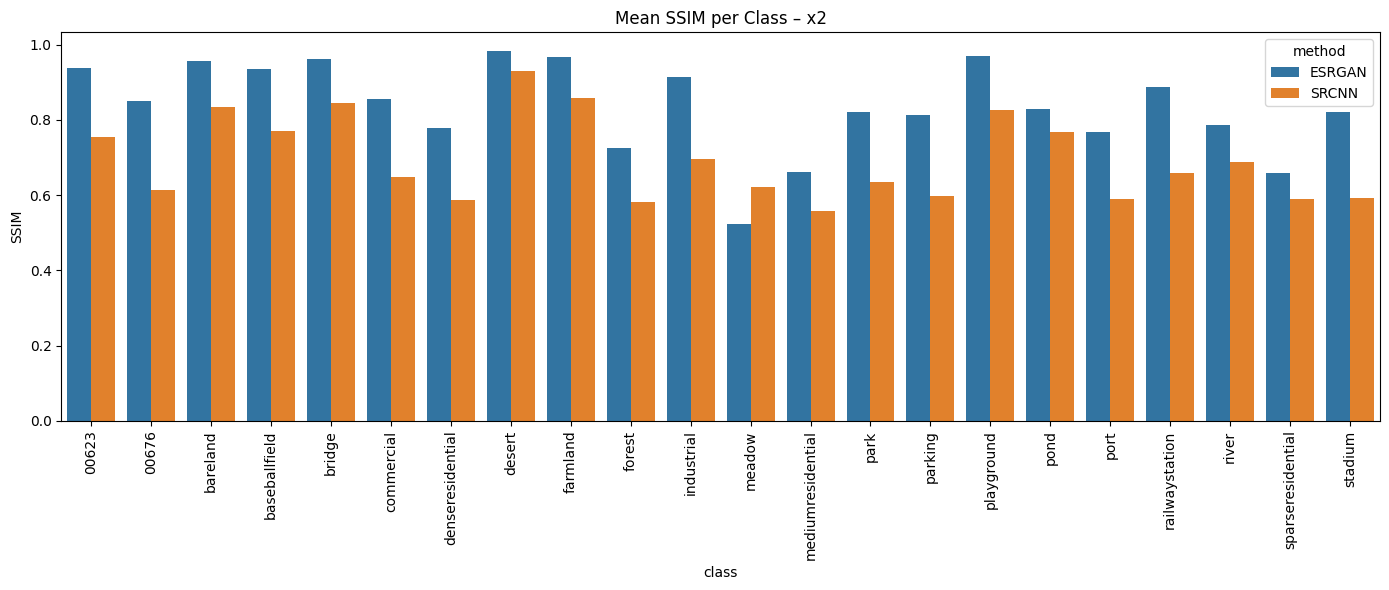

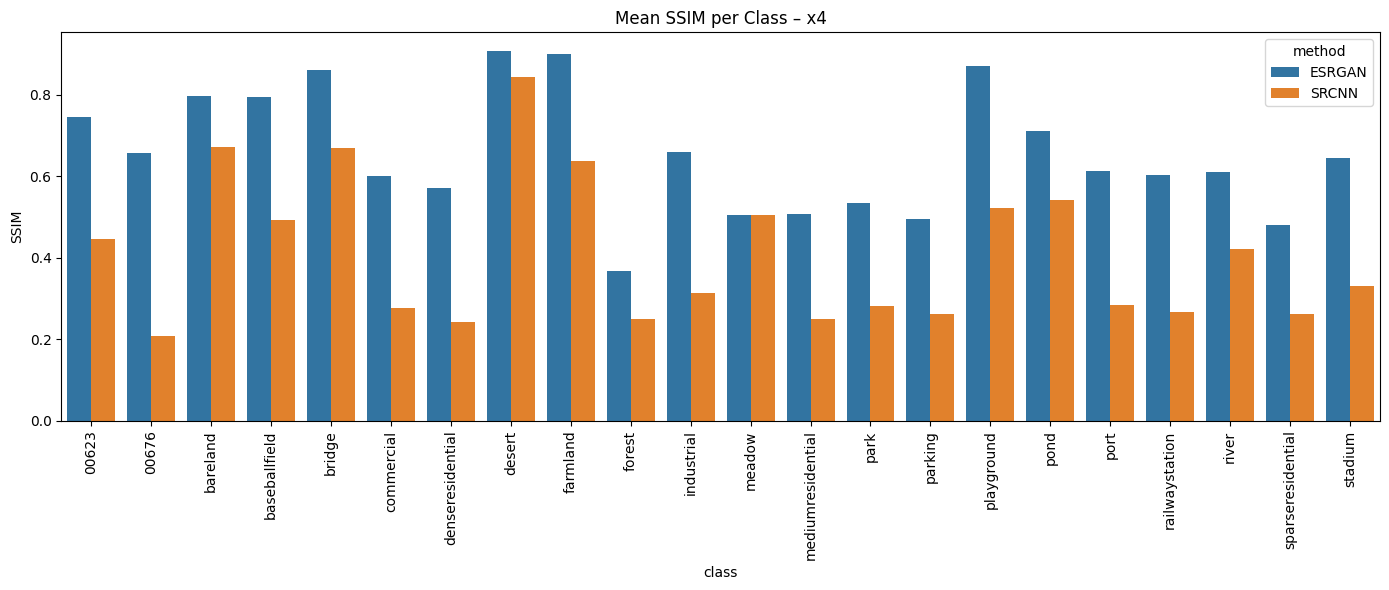

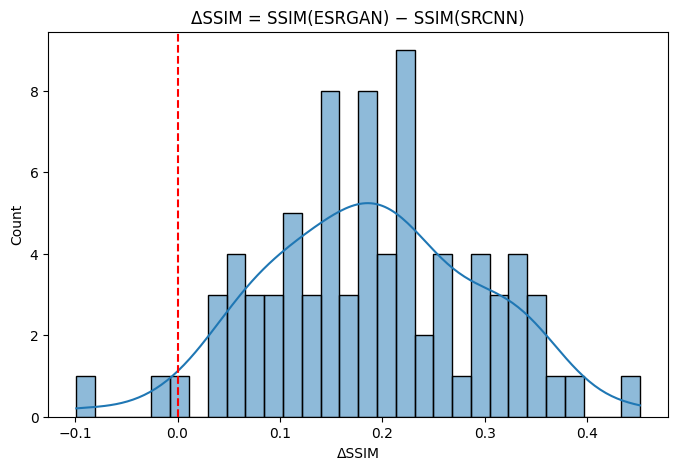

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for scale in ["x2","x4"]:
    data = per_class[per_class["scale"]==scale]
    plt.figure(figsize=(14,6))
    sns.barplot(x="class", y="SSIM", hue="method", data=data)
    plt.xticks(rotation=90)
    plt.title(f"Mean SSIM per Class – {scale}")
    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/SuperResolutionProject/results/visuals/ssim_per_class_{scale}.png")

df_pivot = df.pivot_table(index=["class","image","scale"],
                          columns="method", values="SSIM").reset_index()
df_pivot["ΔSSIM"] = df_pivot["ESRGAN"] - df_pivot["SRCNN"]

plt.figure(figsize=(8,5))
sns.histplot(df_pivot["ΔSSIM"], bins=30, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.title("ΔSSIM = SSIM(ESRGAN) − SSIM(SRCNN)")
plt.savefig("/content/drive/MyDrive/SuperResolutionProject/results/visuals/delta_ssim_hist.png")

def show_panel(lr, srcnn, esrgan, hr, title):
    fig, axes = plt.subplots(1,4, figsize=(16,4))
    for ax,img,label in zip(axes, [lr,srcnn,esrgan,hr], ["LR","SRCNN","ESRGAN","HR"]):
        ax.imshow(img)
        ax.set_title(label)
        ax.axis("off")
    plt.suptitle(title)
    plt.savefig(f"/content/drive/MyDrive/SuperResolutionProject/results/visuals/qualitative_{title}.png")


This cell defines paths to the various image directories and a helper function `read_rgb` to read images in RGB format using OpenCV. It then defines the `save_image_panel` function which takes an image stem name, constructs the paths to the corresponding LR, HR, SRCNN, and ESRGAN images for both x2 and x4 scales, reads them, and plots a panel comparing all these images. The panel is saved as a high-resolution PNG file. The cell then demonstrates the usage of `save_image_panel` with an example image stem "baseballfield_60".

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# === Paths ===
HR_DIR   = "/content/drive/MyDrive/SuperResolutionProject/data/processed/HR"
LR_X2    = "/content/drive/MyDrive/SuperResolutionProject/data/processed/LR_x2"
LR_X4    = "/content/drive/MyDrive/SuperResolutionProject/data/processed/LR_x4"
SRCNN_X2 = "/content/drive/MyDrive/SuperResolutionProject/results/SRCNN_x2"
SRCNN_X4 = "/content/drive/MyDrive/SuperResolutionProject/results/SRCNN_x4"
ESRGAN_X2 = "/content/drive/MyDrive/SuperResolutionProject/results/ESRGAN_x2"
ESRGAN_X4 = "/content/drive/MyDrive/SuperResolutionProject/results/ESRGAN_x4"

VISUALS_DIR = "/content/drive/MyDrive/SuperResolutionProject/results/visuals"
os.makedirs(VISUALS_DIR, exist_ok=True)

def read_rgb(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img is not None else None

def save_image_panel(stem):
    # Build paths
    hr_path     = os.path.join(HR_DIR, stem + ".png")
    lr2_path    = os.path.join(LR_X2, stem + "_x2.png")
    lr4_path    = os.path.join(LR_X4, stem + "_x4.png")
    srcnn2_path = os.path.join(SRCNN_X2, stem + "_x2.png")
    srcnn4_path = os.path.join(SRCNN_X4, stem + "_x4.png")
    esrgan2_path = os.path.join(ESRGAN_X2, stem + "_x2_ESRGAN.png")
    esrgan4_path = os.path.join(ESRGAN_X4, stem + "_x4_ESRGAN.png")

    # Read
    imgs = [
        ("HR", read_rgb(hr_path)),
        ("LR ×2", read_rgb(lr2_path)),
        ("SRCNN ×2", read_rgb(srcnn2_path)),
        ("ESRGAN ×2", read_rgb(esrgan2_path)),
        ("LR ×4", read_rgb(lr4_path)),
        ("SRCNN ×4", read_rgb(srcnn4_path)),
        ("ESRGAN ×4", read_rgb(esrgan4_path)),
    ]

    # Plot — bigger figure
    fig, axes = plt.subplots(2, 4, figsize=(22, 12))  # larger size
    axes = axes.flatten()
    for ax, (title, img) in zip(axes, imgs):
        if img is not None:
            ax.imshow(img)
            ax.set_title(title, fontsize=14)
        ax.axis("off")

    # Global title
    plt.suptitle(f"Super-Resolution Comparison Panel: {stem}", fontsize=18, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for title

    # Save to visuals folder
    out_path = os.path.join(VISUALS_DIR, f"{stem}_panel.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"✅ Saved panel visualization to {out_path}")

# Example usage
save_image_panel("baseballfield_60")


✅ Saved panel visualization to /content/drive/MyDrive/SuperResolutionProject/results/visuals/baseballfield_60_panel.png
